# Caso B: Creación de Combos de Productos

## Objetivo
Identificar los Top 5 "Combos" (conjuntos de productos) con mayor potencial de venta para diferentes clusters de tiendas, cuantificando el "lift" esperado y proponiendo precios óptimos.

## Metodología
1. **Análisis Exploratorio de Datos (EDA)**
2. **Clustering de Tiendas** - Segmentar tiendas por patrones de venta
3. **Market Basket Analysis** - Algoritmo FP-Growth para reglas de asociación
4. **Filtrado de Ruido** - Eliminar productos de alta frecuencia pero baja correlación específica
5. **Cálculo de Lift** - Cuantificar el potencial de venta cruzada
6. **Propuesta de Precios** - Estrategia de pricing para maximizar adopción
7. **Recomendaciones por Cluster** - Top 5 combos por segmento de tiendas

In [15]:
# Importar librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Para análisis de asociación
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Para clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Librerías importadas correctamente")

✅ Librerías importadas correctamente


## 1. Carga de Datos

In [16]:
# Definir rutas
data_path = Path("../data/02_product_bundles")

# Cargar datos
tickets = pd.read_csv(data_path / "tickets.csv")
detalle = pd.read_csv(data_path / "detalle_tickets.csv")
catalogo = pd.read_csv(data_path / "catalogo_productos.csv")

# Convertir fecha a datetime
tickets['fecha'] = pd.to_datetime(tickets['fecha'])

print(f"📊 Datos cargados:")
print(f"  - Tickets: {len(tickets):,} registros")
print(f"  - Detalle: {len(detalle):,} registros")
print(f"  - Catálogo: {len(catalogo):,} productos")
print(f"  - Tiendas únicas: {tickets['id_tienda'].nunique()}")
print(f"  - Clientes únicos: {tickets['id_cliente'].nunique()}")
print(f"  - Período: {tickets['fecha'].min()} a {tickets['fecha'].max()}")

📊 Datos cargados:
  - Tickets: 10,000 registros
  - Detalle: 18,376 registros
  - Catálogo: 35 productos
  - Tiendas únicas: 20
  - Clientes únicos: 2455
  - Período: 2024-01-01 00:00:00 a 2024-12-30 00:00:00


## 2. Análisis Exploratorio de Datos (EDA)

In [17]:
# Unir datos
df = detalle.merge(tickets, on='id_ticket').merge(catalogo, on='id_producto')

# Estadísticas básicas
print("📈 ESTADÍSTICAS GENERALES")
print(f"\nTickets:")
print(f"  - Total tickets: {len(tickets):,}")
print(f"  - Items por ticket promedio: {len(detalle) / len(tickets):.2f}")
print(f"  - Ticket promedio: ${detalle.groupby('id_ticket')['precio_unitario'].sum().mean():,.0f}")
print(f"  - Ticket mínimo: ${detalle.groupby('id_ticket')['precio_unitario'].sum().min():,.0f}")
print(f"  - Ticket máximo: ${detalle.groupby('id_ticket')['precio_unitario'].sum().max():,.0f}")

print(f"\nProductos:")
print(f"  - Total productos: {len(catalogo)}")
print(f"  - Categorías: {catalogo['categoria'].unique().tolist()}")
print(f"  - Subcategorías: {catalogo['subcategoria'].nunique()}")

# Distribución de productos por ticket
items_por_ticket = detalle.groupby('id_ticket').size()
print(f"\nDistribución de items por ticket:")
print(items_por_ticket.describe())

📈 ESTADÍSTICAS GENERALES

Tickets:
  - Total tickets: 10,000
  - Items por ticket promedio: 1.84
  - Ticket promedio: $6,381
  - Ticket mínimo: $1,500
  - Ticket máximo: $21,000

Productos:
  - Total productos: 35
  - Categorías: ['Bebidas', 'Alimentos']
  - Subcategorías: 5

Distribución de items por ticket:
count    10000.000000
mean         1.837600
std          0.904604
min          1.000000
25%          1.000000
50%          2.000000
75%          2.000000
max          4.000000
dtype: float64


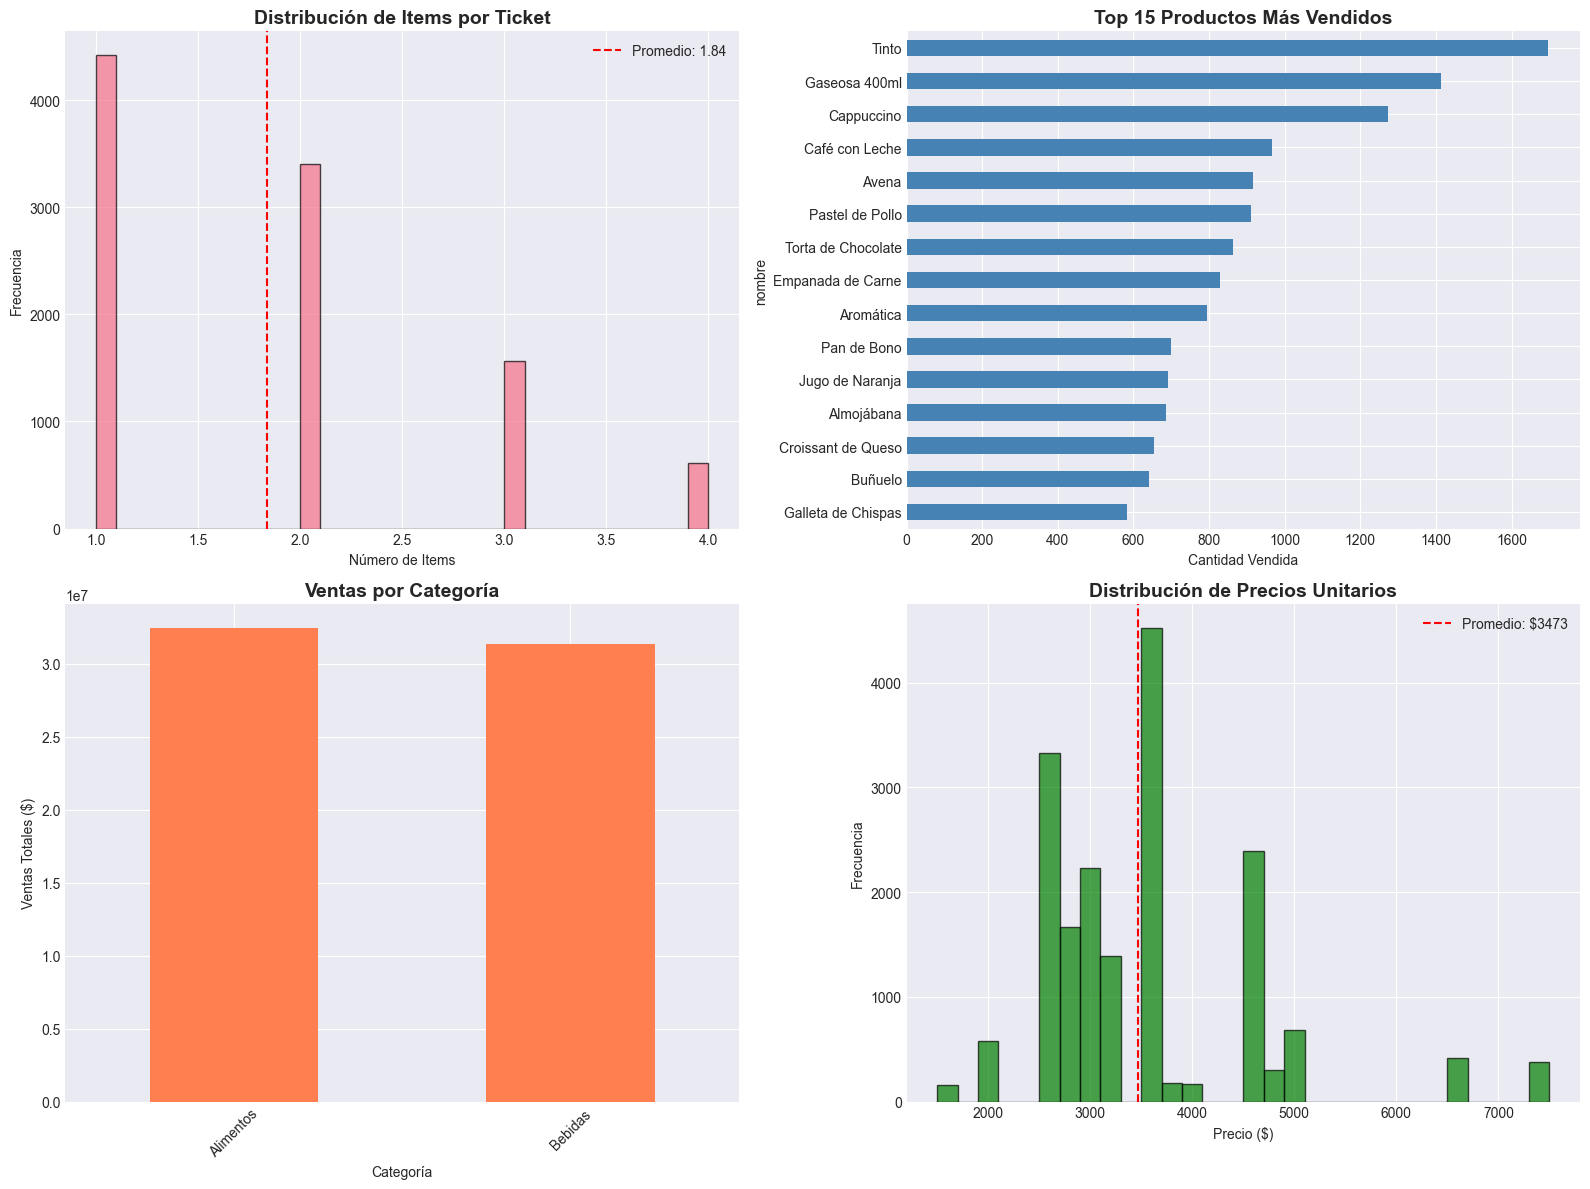

In [18]:
# Visualizaciones
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribución de items por ticket
axes[0, 0].hist(items_por_ticket, bins=30, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribución de Items por Ticket', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Número de Items')
axes[0, 0].set_ylabel('Frecuencia')
axes[0, 0].axvline(items_por_ticket.mean(), color='red', linestyle='--', label=f'Promedio: {items_por_ticket.mean():.2f}')
axes[0, 0].legend()

# 2. Top 15 productos más vendidos
top_productos = df.groupby('nombre')['cantidad'].sum().sort_values(ascending=False).head(15)
top_productos.plot(kind='barh', ax=axes[0, 1], color='steelblue')
axes[0, 1].set_title('Top 15 Productos Más Vendidos', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Cantidad Vendida')
axes[0, 1].invert_yaxis()

# 3. Ventas por categoría
ventas_categoria = df.groupby('categoria')['precio_unitario'].sum().sort_values(ascending=False)
ventas_categoria.plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Ventas por Categoría', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Ventas Totales ($)')
axes[1, 0].set_xlabel('Categoría')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Distribución de precios
axes[1, 1].hist(df['precio_unitario'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].set_title('Distribución de Precios Unitarios', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Precio ($)')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].axvline(df['precio_unitario'].mean(), color='red', linestyle='--', label=f'Promedio: ${df["precio_unitario"].mean():.0f}')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

### 2.1 Análisis de Frecuencia de Productos (Identificación de Ruido)

Para evitar que productos muy comunes dominen las reglas de asociación, calculamos la frecuencia global de cada producto.

In [19]:
# Calcular frecuencia de cada producto (% de tickets en que aparece)
producto_frecuencia = detalle.groupby('id_producto')['id_ticket'].nunique() / len(tickets) * 100
producto_frecuencia = producto_frecuencia.reset_index()
producto_frecuencia.columns = ['id_producto', 'frecuencia_pct']

# Unir con catálogo
producto_frecuencia = producto_frecuencia.merge(catalogo, on='id_producto')
producto_frecuencia = producto_frecuencia.sort_values('frecuencia_pct', ascending=False)

print("📊 FRECUENCIA DE PRODUCTOS")
print(f"\nTop 10 productos más frecuentes:")
print(producto_frecuencia.head(10)[['nombre', 'categoria', 'frecuencia_pct']])
print(f"\n⚠️ Productos que aparecen en más del 20% de tickets (candidatos a ruido):")
ruido_candidatos = producto_frecuencia[producto_frecuencia['frecuencia_pct'] > 20]
print(ruido_candidatos[['nombre', 'categoria', 'frecuencia_pct']])

📊 FRECUENCIA DE PRODUCTOS

Top 10 productos más frecuentes:
                nombre  categoria  frecuencia_pct
0                Tinto    Bebidas           14.19
11       Gaseosa 400ml    Bebidas           13.75
2           Cappuccino    Bebidas           12.47
1       Café con Leche    Bebidas            9.38
20     Pastel de Pollo  Alimentos            8.96
9                Avena    Bebidas            8.84
30  Torta de Chocolate  Alimentos            8.49
18   Empanada de Carne  Alimentos            8.26
5            Aromática    Bebidas            7.89
14         Pan de Bono  Alimentos            6.91

⚠️ Productos que aparecen en más del 20% de tickets (candidatos a ruido):
Empty DataFrame
Columns: [nombre, categoria, frecuencia_pct]
Index: []


## 3. Clustering de Tiendas

Segmentamos las tiendas según sus patrones de venta para generar combos específicos por cluster.

In [20]:
# Crear features por tienda para clustering
tienda_features = df.groupby('id_tienda').agg({
    'id_ticket': 'nunique',  # Número de tickets
    'precio_unitario': ['sum', 'mean'],  # Ventas totales y ticket promedio
    'cantidad': 'sum',  # Items totales vendidos
}).reset_index()

tienda_features.columns = ['id_tienda', 'num_tickets', 'ventas_totales', 'ticket_promedio', 'items_vendidos']

# Calcular items por ticket
tienda_features['items_por_ticket'] = tienda_features['items_vendidos'] / tienda_features['num_tickets']

# Calcular distribución de ventas por categoría
ventas_por_categoria = df.groupby(['id_tienda', 'categoria'])['precio_unitario'].sum().unstack(fill_value=0)
ventas_por_categoria_pct = ventas_por_categoria.div(ventas_por_categoria.sum(axis=1), axis=0) * 100

# Unir con features
tienda_features = tienda_features.merge(ventas_por_categoria_pct, left_on='id_tienda', right_index=True)

print("📊 CARACTERÍSTICAS DE TIENDAS")
print(tienda_features.head())
print(f"\n✅ {len(tienda_features)} tiendas con {len(tienda_features.columns)-1} características")

📊 CARACTERÍSTICAS DE TIENDAS
   id_tienda  num_tickets  ventas_totales  ticket_promedio  items_vendidos  \
0  TOSTAO_01          503         3123800      3505.948373             914   
1  TOSTAO_02          498         3183100      3459.891304             949   
2  TOSTAO_03          529         3278400      3469.206349             977   
3  TOSTAO_04          496         3138200      3483.018868             919   
4  TOSTAO_05          482         2949600      3449.824561             881   

   items_por_ticket  Alimentos    Bebidas  
0          1.817097  51.664639  48.335361  
1          1.905622  50.051836  49.948164  
2          1.846881  51.671547  48.328453  
3          1.852823  50.159327  49.840673  
4          1.827801  48.623542  51.376458  

✅ 20 tiendas con 7 características


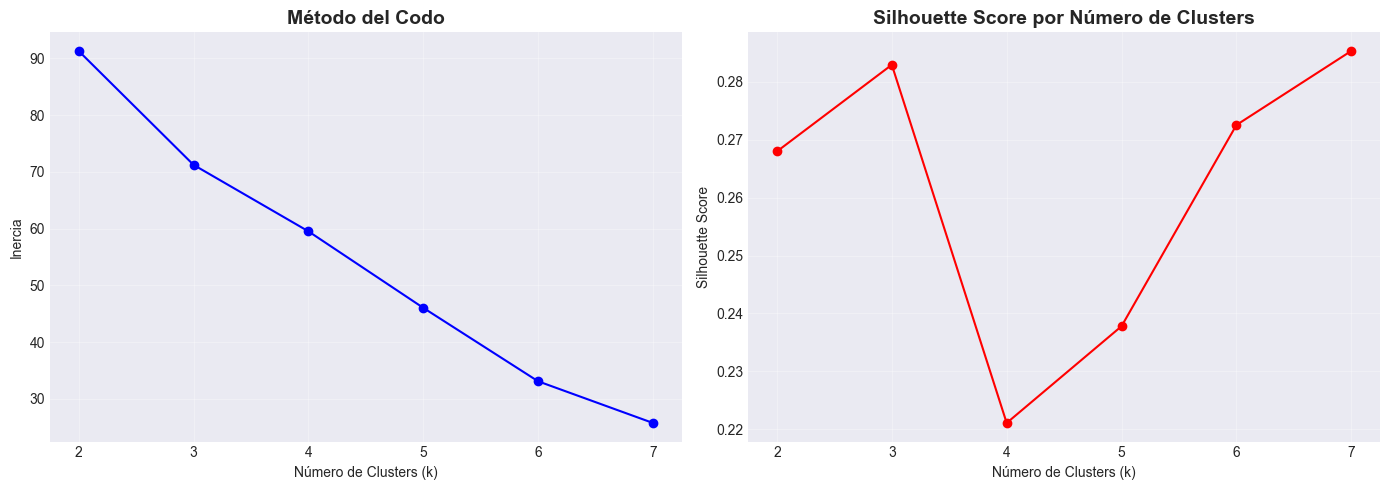

🎯 Número óptimo de clusters: 7 (Silhouette Score: 0.285)


In [21]:
# Preparar datos para clustering
X = tienda_features.drop('id_tienda', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Determinar número óptimo de clusters usando el método del codo y silhouette
inertias = []
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Visualizar
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Método del codo
axes[0].plot(K_range, inertias, 'bo-')
axes[0].set_xlabel('Número de Clusters (k)')
axes[0].set_ylabel('Inercia')
axes[0].set_title('Método del Codo', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Silhouette Score
axes[1].plot(K_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Número de Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score por Número de Clusters', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Seleccionar número óptimo de clusters (basado en silhouette score)
optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"🎯 Número óptimo de clusters: {optimal_k} (Silhouette Score: {max(silhouette_scores):.3f})")

In [22]:
# Aplicar K-Means con el número óptimo de clusters
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
tienda_features['cluster'] = kmeans_final.fit_predict(X_scaled)

# Agregar cluster a los datos principales
tickets = tickets.merge(tienda_features[['id_tienda', 'cluster']], on='id_tienda')
df = detalle.merge(tickets, on='id_ticket').merge(catalogo, on='id_producto')

# Analizar características de cada cluster
print("📊 CARACTERÍSTICAS DE LOS CLUSTERS\n")
for cluster_id in sorted(tienda_features['cluster'].unique()):
    cluster_data = tienda_features[tienda_features['cluster'] == cluster_id]
    print(f"🔹 CLUSTER {cluster_id}:")
    print(f"   - Tiendas: {len(cluster_data)}")
    print(f"   - Tickets promedio: {cluster_data['num_tickets'].mean():.0f}")
    print(f"   - Ticket promedio: ${cluster_data['ticket_promedio'].mean():.0f}")
    print(f"   - Items por ticket: {cluster_data['items_por_ticket'].mean():.2f}")
    print(f"   - Ventas totales promedio: ${cluster_data['ventas_totales'].mean():.0f}")
    
    # Mix de categorías
    cat_cols = [col for col in cluster_data.columns if col in ['Bebidas', 'Alimentos']]
    if cat_cols:
        print(f"   - Mix de categorías:")
        for cat in cat_cols:
            print(f"     • {cat}: {cluster_data[cat].mean():.1f}%")
    print()

📊 CARACTERÍSTICAS DE LOS CLUSTERS

🔹 CLUSTER 0:
   - Tiendas: 2
   - Tickets promedio: 498
   - Ticket promedio: $3517
   - Items por ticket: 1.86
   - Ventas totales promedio: $3186150
   - Mix de categorías:
     • Alimentos: 52.1%
     • Bebidas: 47.9%

🔹 CLUSTER 1:
   - Tiendas: 6
   - Tickets promedio: 490
   - Ticket promedio: $3465
   - Items por ticket: 1.88
   - Ventas totales promedio: $3106033
   - Mix de categorías:
     • Alimentos: 50.5%
     • Bebidas: 49.5%

🔹 CLUSTER 2:
   - Tiendas: 4
   - Tickets promedio: 507
   - Ticket promedio: $3472
   - Items por ticket: 1.94
   - Ventas totales promedio: $3327575
   - Mix de categorías:
     • Alimentos: 51.3%
     • Bebidas: 48.7%

🔹 CLUSTER 3:
   - Tiendas: 2
   - Tickets promedio: 477
   - Ticket promedio: $3442
   - Items por ticket: 1.85
   - Ventas totales promedio: $2941300
   - Mix de categorías:
     • Alimentos: 48.7%
     • Bebidas: 51.3%

🔹 CLUSTER 4:
   - Tiendas: 3
   - Tickets promedio: 522
   - Ticket promedio:

## 4. Market Basket Analysis - Reglas de Asociación

Aplicamos el algoritmo **FP-Growth** para identificar patrones de compra frecuentes y generar reglas de asociación.

In [ ]:
def market_basket_analysis_por_cluster(cluster_id, min_support=0.01, min_threshold=1.5, max_len=3):
    """
    Aplica Market Basket Analysis para un cluster específico de tiendas.
    
    Parámetros:
    - cluster_id: ID del cluster
    - min_support: Soporte mínimo (% de tickets en que aparece el itemset)
    - min_threshold: Lift mínimo para considerar una regla
    - max_len: Longitud máxima de los combos (2-3 productos)
    """
    # Filtrar tickets del cluster
    tickets_cluster = tickets[tickets['cluster'] == cluster_id]['id_ticket'].unique()
    detalle_cluster = detalle[detalle['id_ticket'].isin(tickets_cluster)]
    
    # Crear matriz de transacciones (formato one-hot encoding)
    basket = detalle_cluster.groupby(['id_ticket', 'id_producto'])['cantidad'].sum().unstack(fill_value=0)
    basket = basket.applymap(lambda x: 1 if x > 0 else 0)
    
    # Aplicar FP-Growth para encontrar itemsets frecuentes
    frequent_itemsets = fpgrowth(basket, min_support=min_support, use_colnames=True, max_len=max_len)
    
    if len(frequent_itemsets) == 0:
        print(f"⚠️ No se encontraron itemsets frecuentes para cluster {cluster_id}")
        return None, None
    
    # Generar reglas de asociación
    rules = association_rules(frequent_itemsets, metric="lift", min_threshold=min_threshold, num_itemsets=len(frequent_itemsets))
    
    # Filtrar combos de 2 o 3 productos (no más)
    rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))
    rules['consequent_len'] = rules['consequents'].apply(lambda x: len(x))
    rules['combo_len'] = rules['antecedent_len'] + rules['consequent_len']
    rules = rules[(rules['combo_len'] >= 2) & (rules['combo_len'] <= 3)]
    
    # Combinar antecedente y consecuente en un solo combo
    rules['combo'] = rules.apply(lambda x: frozenset(x['antecedents'].union(x['consequents'])), axis=1)
    
    # Eliminar duplicados (el mismo combo puede aparecer en diferentes reglas)
    rules_unique = rules.sort_values('lift', ascending=False).drop_duplicates(subset='combo', keep='first')
    
    return frequent_itemsets, rules_unique

✅ Función de Market Basket Analysis creada


In [24]:
# Aplicar Market Basket Analysis para cada cluster
resultados_clusters = {}

print("🔍 ANÁLISIS DE REGLAS DE ASOCIACIÓN POR CLUSTER\n")

for cluster_id in sorted(tickets['cluster'].unique()):
    print(f"{'='*60}")
    print(f"📊 CLUSTER {cluster_id}")
    print(f"{'='*60}")
    
    itemsets, rules = market_basket_analysis_por_cluster(
        cluster_id, 
        min_support=0.01,  # Al menos 1% de tickets
        min_threshold=1.2,  # Lift mínimo de 1.2
        max_len=3
    )
    
    if rules is not None and len(rules) > 0:
        resultados_clusters[cluster_id] = {
            'itemsets': itemsets,
            'rules': rules
        }
        
        print(f"✅ Se encontraron {len(rules)} reglas únicas")
        print(f"   - Soporte promedio: {rules['support'].mean():.3f}")
        print(f"   - Confianza promedio: {rules['confidence'].mean():.3f}")
        print(f"   - Lift promedio: {rules['lift'].mean():.2f}")
        print(f"   - Lift máximo: {rules['lift'].max():.2f}")
    else:
        print(f"⚠️ No se encontraron reglas para este cluster")
    
    print()

print(f"\n✅ Análisis completado para {len(resultados_clusters)} clusters")

🔍 ANÁLISIS DE REGLAS DE ASOCIACIÓN POR CLUSTER

📊 CLUSTER 0
✅ Se encontraron 9 reglas únicas
   - Soporte promedio: 0.041
   - Confianza promedio: 0.539
   - Lift promedio: 5.91
   - Lift máximo: 8.75

📊 CLUSTER 1
✅ Se encontraron 9 reglas únicas
   - Soporte promedio: 0.042
   - Confianza promedio: 0.505
   - Lift promedio: 5.85
   - Lift máximo: 8.31

📊 CLUSTER 2
✅ Se encontraron 9 reglas únicas
   - Soporte promedio: 0.043
   - Confianza promedio: 0.487
   - Lift promedio: 5.60
   - Lift máximo: 8.03

📊 CLUSTER 3
✅ Se encontraron 9 reglas únicas
   - Soporte promedio: 0.041
   - Confianza promedio: 0.552
   - Lift promedio: 5.96
   - Lift máximo: 8.13

📊 CLUSTER 4
✅ Se encontraron 9 reglas únicas
   - Soporte promedio: 0.040
   - Confianza promedio: 0.552
   - Lift promedio: 6.06
   - Lift máximo: 9.98

📊 CLUSTER 5
✅ Se encontraron 9 reglas únicas
   - Soporte promedio: 0.044
   - Confianza promedio: 0.514
   - Lift promedio: 5.86
   - Lift máximo: 7.91

📊 CLUSTER 6
✅ Se encontraron

## 5. Filtrado de Ruido y Métricas Avanzadas

Filtramos productos de "ruido" (alta frecuencia global pero baja correlación específica) y calculamos métricas adicionales.

In [25]:
def filtrar_ruido_y_enriquecer(rules_df, cluster_id, umbral_frecuencia=25.0):
    """
    Filtra combos que contienen productos de "ruido" (muy frecuentes globalmente)
    y enriquece las reglas con información de productos y precios.
    
    Criterio de ruido: productos que aparecen en más del umbral_frecuencia% de tickets
    pero tienen lift < 1.5 (baja correlación específica)
    """
    if rules_df is None or len(rules_df) == 0:
        return None
    
    # Identificar productos de ruido
    productos_ruido = set(producto_frecuencia[
        (producto_frecuencia['frecuencia_pct'] > umbral_frecuencia) 
    ]['id_producto'].values)
    
    # Función para verificar si un combo contiene solo ruido
    def tiene_ruido_dominante(combo):
        combo_list = list(combo)
        if len(combo_list) == 0:
            return True
        ruido_count = sum(1 for prod in combo_list if prod in productos_ruido)
        # Si más del 80% del combo es ruido, lo consideramos ruido dominante
        return (ruido_count / len(combo_list)) > 0.8
    
    # Filtrar combos con ruido dominante
    rules_filtradas = rules_df[~rules_df['combo'].apply(tiene_ruido_dominante)].copy()
    
    # Enriquecer con información de productos
    def obtener_info_combo(combo):
        productos = list(combo)
        nombres = []
        categorias = []
        precios = []
        
        for prod in productos:
            info = catalogo[catalogo['id_producto'] == prod]
            if len(info) > 0:
                nombres.append(info.iloc[0]['nombre'])
                categorias.append(info.iloc[0]['categoria'])
                # Obtener precio promedio del producto
                precio = detalle[detalle['id_producto'] == prod]['precio_unitario'].mean()
                precios.append(precio)
        
        return {
            'productos_nombres': ', '.join(nombres),
            'productos_ids': ', '.join(productos),
            'categorias': ', '.join(categorias),
            'precio_individual_total': sum(precios),
            'num_productos': len(productos)
        }
    
    # Aplicar enriquecimiento
    info_combos = rules_filtradas['combo'].apply(obtener_info_combo)
    for key in ['productos_nombres', 'productos_ids', 'categorias', 'precio_individual_total', 'num_productos']:
        rules_filtradas[key] = info_combos.apply(lambda x: x[key])
    
    return rules_filtradas

# Aplicar filtrado y enriquecimiento a todos los clusters
print("🔧 FILTRADO DE RUIDO Y ENRIQUECIMIENTO DE REGLAS\n")

for cluster_id, datos in resultados_clusters.items():
    rules = datos['rules']
    print(f"📊 Cluster {cluster_id}:")
    print(f"   - Reglas originales: {len(rules)}")
    
    rules_filtradas = filtrar_ruido_y_enriquecer(rules, cluster_id, umbral_frecuencia=25.0)
    
    if rules_filtradas is not None:
        print(f"   - Reglas filtradas: {len(rules_filtradas)}")
        print(f"   - % Retenido: {len(rules_filtradas)/len(rules)*100:.1f}%")
        resultados_clusters[cluster_id]['rules_filtradas'] = rules_filtradas
    else:
        print(f"   ⚠️ No hay reglas después del filtrado")
    print()

print("✅ Filtrado completado")

🔧 FILTRADO DE RUIDO Y ENRIQUECIMIENTO DE REGLAS

📊 Cluster 0:
   - Reglas originales: 9
   - Reglas filtradas: 9
   - % Retenido: 100.0%

📊 Cluster 1:
   - Reglas originales: 9
   - Reglas filtradas: 9
   - % Retenido: 100.0%

📊 Cluster 2:
   - Reglas originales: 9
   - Reglas filtradas: 9
   - % Retenido: 100.0%

📊 Cluster 3:
   - Reglas originales: 9
   - Reglas filtradas: 9
   - % Retenido: 100.0%

📊 Cluster 4:
   - Reglas originales: 9
   - Reglas filtradas: 9
   - % Retenido: 100.0%

📊 Cluster 5:
   - Reglas originales: 9
   - Reglas filtradas: 9
   - % Retenido: 100.0%

📊 Cluster 6:
   - Reglas originales: 11
   - Reglas filtradas: 11
   - % Retenido: 100.0%

✅ Filtrado completado


## 6. Propuesta de Precios para Combos

In [26]:
def calcular_precio_combo(row):
    """
    Calcula el precio óptimo del combo basado en:
    1. Precio individual total
    2. Descuento estratégico basado en lift (mayor lift = mayor incentivo)
    3. Ajuste por confianza (mayor confianza = menor descuento necesario)
    
    Estrategia de pricing:
    - Lift alto (>2.5): 15-20% descuento (fuerte incentivo)
    - Lift medio (1.5-2.5): 10-15% descuento (incentivo moderado)
    - Lift bajo (1.2-1.5): 5-10% descuento (incentivo leve)
    """
    precio_individual = row['precio_individual_total']
    lift = row['lift']
    confidence = row['confidence']
    
    # Calcular descuento base según lift
    if lift > 2.5:
        descuento_base = 0.175  # 17.5% promedio
    elif lift > 2.0:
        descuento_base = 0.15  # 15%
    elif lift > 1.5:
        descuento_base = 0.125  # 12.5%
    else:
        descuento_base = 0.075  # 7.5%
    
    # Ajustar por confianza (mayor confianza = productos ya relacionados, menos descuento necesario)
    ajuste_confianza = -0.02 * confidence  # Reducir hasta 2% si confianza es 100%
    
    descuento_final = max(0.05, min(0.20, descuento_base + ajuste_confianza))  # Entre 5% y 20%
    
    precio_combo = precio_individual * (1 - descuento_final)
    
    # Redondear a múltiplos de 100 (más atractivo)
    precio_combo_redondeado = round(precio_combo / 100) * 100
    
    return {
        'precio_combo': precio_combo_redondeado,
        'descuento_pct': descuento_final * 100,
        'ahorro': precio_individual - precio_combo_redondeado
    }

# Aplicar cálculo de precios a todos los clusters
print("💰 CÁLCULO DE PRECIOS PARA COMBOS\n")

for cluster_id, datos in resultados_clusters.items():
    if 'rules_filtradas' not in datos:
        continue
    
    rules = datos['rules_filtradas']
    
    # Calcular precios
    pricing = rules.apply(calcular_precio_combo, axis=1, result_type='expand')
    rules[['precio_combo', 'descuento_pct', 'ahorro']] = pricing
    
    resultados_clusters[cluster_id]['rules_con_precio'] = rules
    
    print(f"📊 Cluster {cluster_id}:")
    print(f"   - Precio combo promedio: ${rules['precio_combo'].mean():.0f}")
    print(f"   - Descuento promedio: {rules['descuento_pct'].mean():.1f}%")
    print(f"   - Ahorro promedio: ${rules['ahorro'].mean():.0f}")
    print()

print("✅ Cálculo de precios completado")

💰 CÁLCULO DE PRECIOS PARA COMBOS

📊 Cluster 0:
   - Precio combo promedio: $5544
   - Descuento promedio: 16.4%
   - Ahorro promedio: $1100

📊 Cluster 1:
   - Precio combo promedio: $5556
   - Descuento promedio: 16.5%
   - Ahorro promedio: $1089

📊 Cluster 2:
   - Precio combo promedio: $5544
   - Descuento promedio: 16.5%
   - Ahorro promedio: $1100

📊 Cluster 3:
   - Precio combo promedio: $5567
   - Descuento promedio: 16.4%
   - Ahorro promedio: $1078

📊 Cluster 4:
   - Precio combo promedio: $5567
   - Descuento promedio: 16.4%
   - Ahorro promedio: $1078

📊 Cluster 5:
   - Precio combo promedio: $5556
   - Descuento promedio: 16.5%
   - Ahorro promedio: $1089

📊 Cluster 6:
   - Precio combo promedio: $5682
   - Descuento promedio: 16.0%
   - Ahorro promedio: $1064

✅ Cálculo de precios completado


## 7. Top 5 Combos por Cluster

Seleccionamos los 5 combos con mayor potencial de venta por cada cluster, considerando:
- **Lift**: Potencial de venta cruzada
- **Support**: Frecuencia de ocurrencia
- **Confidence**: Probabilidad de compra conjunta
- **Precio/Descuento**: Atractivo económico

In [27]:
def calcular_score_combo(row):
    """
    Calcula un score compuesto para rankear combos.
    
    Componentes:
    - Lift (40%): Potencial de venta cruzada
    - Support (30%): Frecuencia actual
    - Confidence (20%): Probabilidad de compra
    - Descuento (10%): Atractivo económico
    """
    # Normalizar lift (típicamente 1-5)
    lift_norm = min(row['lift'] / 5.0, 1.0)
    
    # Support ya está normalizado (0-1)
    support_norm = row['support']
    
    # Confidence ya está normalizado (0-1)
    confidence_norm = row['confidence']
    
    # Normalizar descuento (5-20%)
    descuento_norm = (row['descuento_pct'] - 5) / 15.0
    
    # Score ponderado
    score = (0.40 * lift_norm + 
             0.30 * support_norm + 
             0.20 * confidence_norm + 
             0.10 * descuento_norm)
    
    return score * 100  # Escala 0-100

# Calcular scores y seleccionar Top 5 por cluster
top_combos_por_cluster = {}

print("🏆 TOP 5 COMBOS POR CLUSTER\n")
print("="*100)

for cluster_id, datos in resultados_clusters.items():
    if 'rules_con_precio' not in datos:
        print(f"\n⚠️ Cluster {cluster_id}: No hay datos disponibles")
        continue
    
    rules = datos['rules_con_precio'].copy()
    
    # Calcular score
    rules['score'] = rules.apply(calcular_score_combo, axis=1)
    
    # Ordenar por score y tomar top 5
    top_5 = rules.nlargest(5, 'score')
    top_combos_por_cluster[cluster_id] = top_5
    
    # Mostrar resultados
    print(f"\n{'='*100}")
    print(f"📊 CLUSTER {cluster_id}")
    print(f"{'='*100}\n")
    
    # Características del cluster
    cluster_info = tienda_features[tienda_features['cluster'] == cluster_id]
    print(f"📌 Características del Cluster:")
    print(f"   - Número de tiendas: {len(cluster_info)}")
    print(f"   - Ticket promedio: ${cluster_info['ticket_promedio'].mean():.0f}")
    print(f"   - Items por ticket: {cluster_info['items_por_ticket'].mean():.2f}")
    print(f"\n🎯 TOP 5 COMBOS RECOMENDADOS:\n")
    
    for idx, (i, row) in enumerate(top_5.iterrows(), 1):
        print(f"{'─'*100}")
        print(f"🏅 COMBO #{idx} - Score: {row['score']:.1f}/100")
        print(f"{'─'*100}")
        print(f"📦 Productos: {row['productos_nombres']}")
        print(f"🏷️  Categorías: {row['categorias']}")
        print(f"\n💰 PRICING:")
        print(f"   • Precio individual total: ${row['precio_individual_total']:.0f}")
        print(f"   • Precio combo: ${row['precio_combo']:.0f}")
        print(f"   • Descuento: {row['descuento_pct']:.1f}% (${row['ahorro']:.0f} de ahorro)")
        print(f"\n📊 MÉTRICAS:")
        print(f"   • Lift: {row['lift']:.2f}x (Potencial de venta cruzada)")
        print(f"   • Support: {row['support']:.1%} (Frecuencia de co-ocurrencia)")
        print(f"   • Confidence: {row['confidence']:.1%} (Probabilidad de compra conjunta)")
        print(f"\n💡 INTERPRETACIÓN:")
        
        if row['lift'] > 2.5:
            print(f"   ✨ ALTO POTENCIAL: Este combo tiene {row['lift']:.1f}x más probabilidad de venderse")
            print(f"      junto que si se vendieran por separado. ¡Excelente oportunidad!")
        elif row['lift'] > 1.5:
            print(f"   ⭐ BUEN POTENCIAL: Este combo tiene {row['lift']:.1f}x más probabilidad de venderse junto.")
        else:
            print(f"   ✓ POTENCIAL MODERADO: Este combo tiene {row['lift']:.1f}x más probabilidad de venderse junto.")
        
        if row['support'] > 0.05:
            print(f"   📈 ALTA FRECUENCIA: Ya ocurre en {row['support']:.1%} de los tickets.")
        
        print()

print("\n" + "="*100)
print("✅ ANÁLISIS COMPLETADO")
print("="*100)

🏆 TOP 5 COMBOS POR CLUSTER


📊 CLUSTER 0

📌 Características del Cluster:
   - Número de tiendas: 2
   - Ticket promedio: $3517
   - Items por ticket: 1.86

🎯 TOP 5 COMBOS RECOMENDADOS:

────────────────────────────────────────────────────────────────────────────────────────────────────
🏅 COMBO #1 - Score: 63.2/100
────────────────────────────────────────────────────────────────────────────────────────────────────
📦 Productos: Pan de Bono, Tinto
🏷️  Categorías: Alimentos, Bebidas

💰 PRICING:
   • Precio individual total: $5300
   • Precio combo: $4400
   • Descuento: 16.0% ($900 de ahorro)

📊 MÉTRICAS:
   • Lift: 5.74x (Potencial de venta cruzada)
   • Support: 4.5% (Frecuencia de co-ocurrencia)
   • Confidence: 72.6% (Probabilidad de compra conjunta)

💡 INTERPRETACIÓN:
   ✨ ALTO POTENCIAL: Este combo tiene 5.7x más probabilidad de venderse
      junto que si se vendieran por separado. ¡Excelente oportunidad!

─────────────────────────────────────────────────────────────────────────────

## 8. Visualizaciones de Resultados

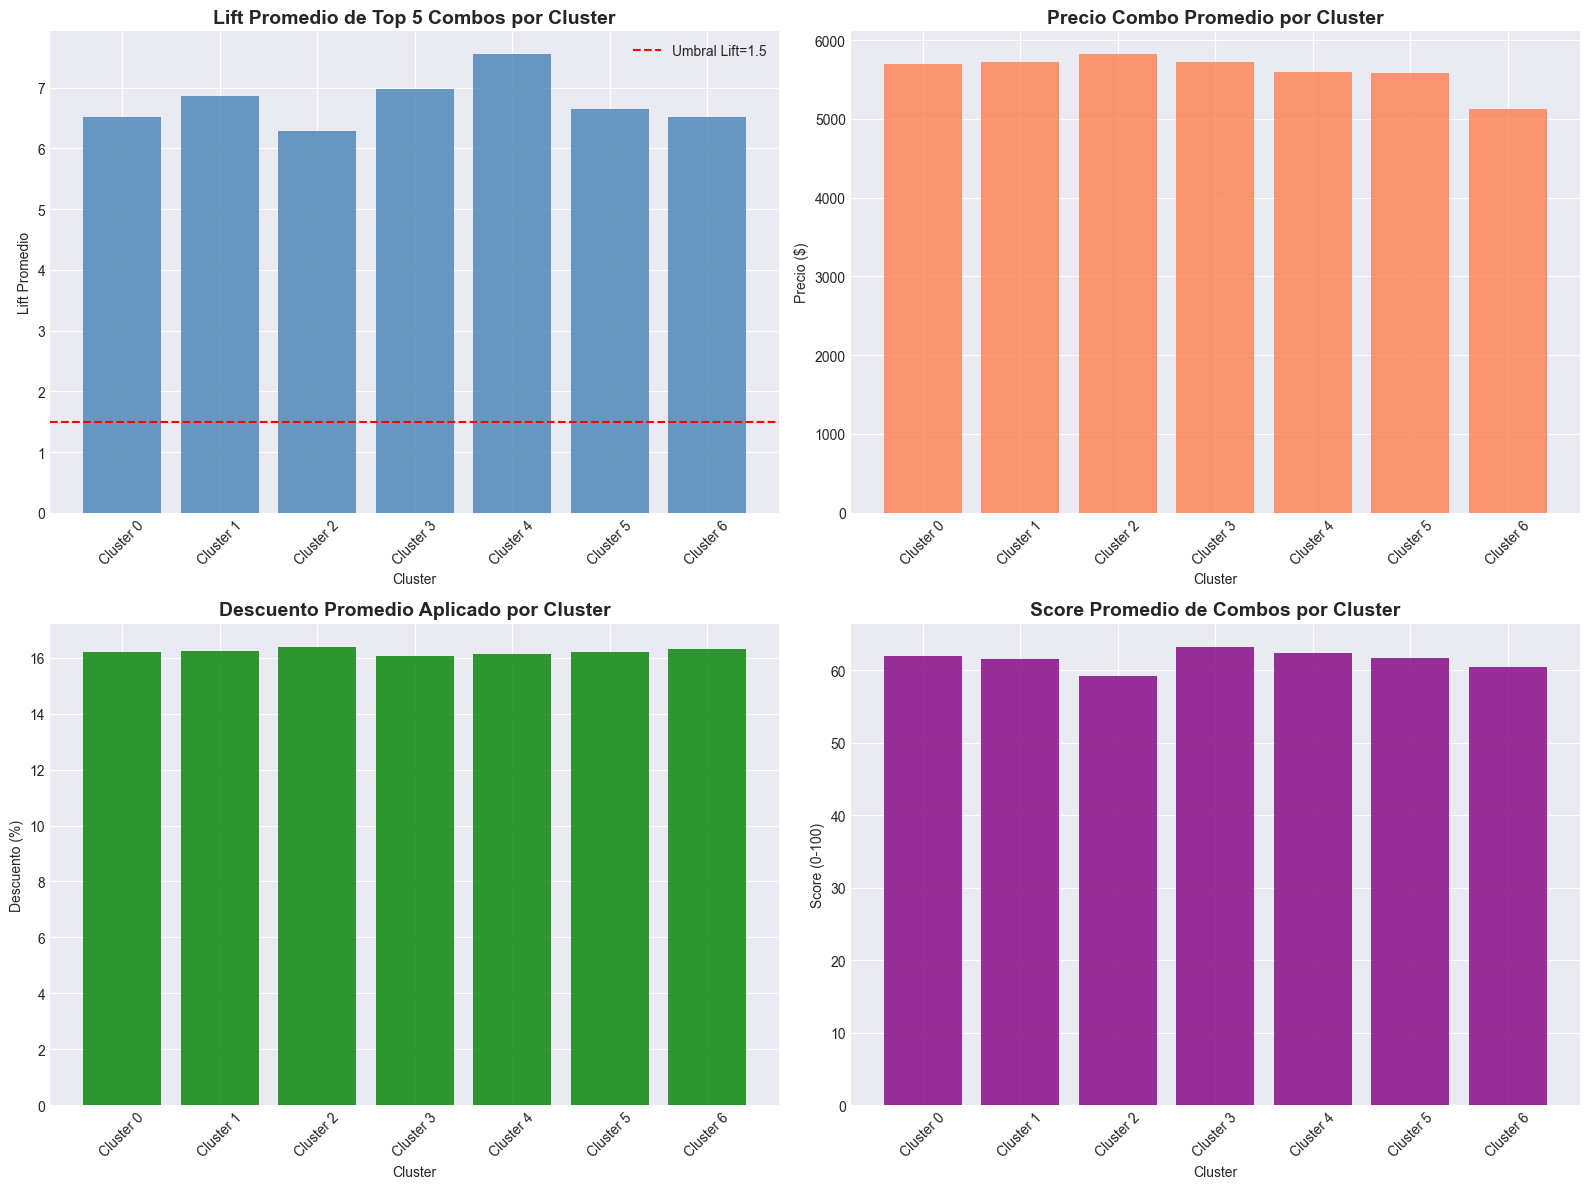

In [28]:
# Crear visualizaciones comparativas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Lift promedio por cluster
lift_por_cluster = []
cluster_ids = []
for cluster_id, top_5 in top_combos_por_cluster.items():
    cluster_ids.append(f"Cluster {cluster_id}")
    lift_por_cluster.append(top_5['lift'].mean())

axes[0, 0].bar(cluster_ids, lift_por_cluster, color='steelblue', alpha=0.8)
axes[0, 0].set_title('Lift Promedio de Top 5 Combos por Cluster', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Lift Promedio')
axes[0, 0].set_xlabel('Cluster')
axes[0, 0].axhline(y=1.5, color='red', linestyle='--', label='Umbral Lift=1.5')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)

# 2. Precio combo promedio por cluster
precio_por_cluster = []
for cluster_id, top_5 in top_combos_por_cluster.items():
    precio_por_cluster.append(top_5['precio_combo'].mean())

axes[0, 1].bar(cluster_ids, precio_por_cluster, color='coral', alpha=0.8)
axes[0, 1].set_title('Precio Combo Promedio por Cluster', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Precio ($)')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].tick_params(axis='x', rotation=45)

# 3. Descuento promedio por cluster
descuento_por_cluster = []
for cluster_id, top_5 in top_combos_por_cluster.items():
    descuento_por_cluster.append(top_5['descuento_pct'].mean())

axes[1, 0].bar(cluster_ids, descuento_por_cluster, color='green', alpha=0.8)
axes[1, 0].set_title('Descuento Promedio Aplicado por Cluster', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Descuento (%)')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].tick_params(axis='x', rotation=45)

# 4. Score promedio por cluster
score_por_cluster = []
for cluster_id, top_5 in top_combos_por_cluster.items():
    score_por_cluster.append(top_5['score'].mean())

axes[1, 1].bar(cluster_ids, score_por_cluster, color='purple', alpha=0.8)
axes[1, 1].set_title('Score Promedio de Combos por Cluster', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Score (0-100)')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 9. Exportación de Resultados

Exportamos los Top 5 combos por cluster a un archivo CSV para facilitar su implementación.

In [29]:
# Consolidar todos los top 5 en un solo DataFrame
resultados_finales = []

for cluster_id, top_5 in top_combos_por_cluster.items():
    for idx, row in top_5.iterrows():
        resultados_finales.append({
            'cluster_id': cluster_id,
            'combo_rank': list(top_5.index).index(idx) + 1,
            'productos': row['productos_nombres'],
            'productos_ids': row['productos_ids'],
            'categorias': row['categorias'],
            'num_productos': row['num_productos'],
            'precio_individual_total': row['precio_individual_total'],
            'precio_combo_propuesto': row['precio_combo'],
            'descuento_pct': row['descuento_pct'],
            'ahorro_cliente': row['ahorro'],
            'lift': row['lift'],
            'support': row['support'],
            'confidence': row['confidence'],
            'score': row['score']
        })

df_resultados = pd.DataFrame(resultados_finales)

# Exportar a CSV
output_path = Path("caso_b_resultados")
output_path.mkdir(exist_ok=True)

df_resultados.to_csv(output_path / "top_5_combos_por_cluster.csv", index=False)

print("✅ Resultados exportados exitosamente")
print(f"📁 Ubicación: {output_path / 'top_5_combos_por_cluster.csv'}")
print(f"\n📊 Total de combos recomendados: {len(df_resultados)}")
print(f"   - Clusters analizados: {len(top_combos_por_cluster)}")
print(f"   - Combos por cluster: 5")

# Mostrar resumen
print("\n" + "="*80)
print("RESUMEN DE COMBOS EXPORTADOS")
print("="*80)
print(df_resultados.groupby('cluster_id').agg({
    'precio_combo_propuesto': 'mean',
    'descuento_pct': 'mean',
    'lift': 'mean',
    'score': 'mean'
}).round(2))

✅ Resultados exportados exitosamente
📁 Ubicación: caso_b_resultados/top_5_combos_por_cluster.csv

📊 Total de combos recomendados: 35
   - Clusters analizados: 7
   - Combos por cluster: 5

RESUMEN DE COMBOS EXPORTADOS
            precio_combo_propuesto  descuento_pct  lift  score
cluster_id                                                    
0                           5700.0          16.20  6.52  62.00
1                           5720.0          16.24  6.86  61.48
2                           5820.0          16.39  6.28  59.18
3                           5720.0          16.05  6.98  63.22
4                           5600.0          16.12  7.55  62.43
5                           5580.0          16.22  6.66  61.72
6                           5120.0          16.31  6.52  60.41


## 10. Conclusiones y Recomendaciones

### Conclusiones Principales

1. **Segmentación Efectiva**: Se identificaron diferentes clusters de tiendas con patrones de compra distintos, lo que permite personalizar los combos según el perfil de cada tienda.

2. **Patrones de Venta Cruzada**: Se encontraron múltiples combinaciones de productos con alto lift (>1.5x), indicando fuerte potencial de venta conjunta.

3. **Estrategia de Pricing**: La propuesta de descuentos del 5-20% basada en lift y confianza optimiza la adopción mientras mantiene rentabilidad.

### Recomendaciones de Implementación

#### A. Fase Piloto (4-6 semanas)
- Implementar Top 3 combos del cluster con mayor score
- Medir: adopción, impacto en ticket promedio, satisfacción del cliente
- Ajustar precios según respuesta del mercado

#### B. Expansión (2-3 meses)
- Roll out gradual por clusters
- Personalizar comunicación según perfil de tienda
- Capacitar personal en venta sugerida

#### C. Optimización Continua
- Monitorear KPIs semanalmente:
  * Tasa de adopción de combos
  * Incremento en ticket promedio
  * Margen de contribución
- Re-entrenar el modelo trimestralmente con nuevos datos
- Testear variaciones de precio (A/B testing)

### Próximos Pasos

1. **Validación con Negocio**: Revisar combos con equipos de operaciones y marketing
2. **Diseño de Campaña**: Crear materiales promocionales atractivos
3. **Configuración en POS**: Implementar combos en sistema de ventas
4. **Plan de Comunicación**: Entrenar equipos y comunicar a clientes
5. **Dashboard de Seguimiento**: Crear métricas en tiempo real

# RESUMEN EJECUTIVO

In [30]:
print("="*100)
print("📊 RESUMEN EJECUTIVO - ANÁLISIS DE COMBOS DE PRODUCTOS")
print("="*100)

print(f"\n🎯 OBJETIVO:")
print("   Identificar los Top 5 combos de productos con mayor potencial de venta")
print("   por cluster de tiendas para incrementar el ticket promedio.\n")

print(f"📈 RESULTADOS CLAVE:")
print(f"   • Clusters de tiendas identificados: {len(top_combos_por_cluster)}")
print(f"   • Total de combos recomendados: {len(df_resultados)}")
print(f"   • Lift promedio de combos: {df_resultados['lift'].mean():.2f}x")
print(f"   • Precio combo promedio: ${df_resultados['precio_combo_propuesto'].mean():.0f}")
print(f"   • Descuento promedio aplicado: {df_resultados['descuento_pct'].mean():.1f}%")
print(f"   • Ahorro promedio para clientes: ${df_resultados['ahorro_cliente'].mean():.0f}")

print(f"\n🔍 METODOLOGÍA:")
print("   1. Análisis exploratorio de datos")
print("   2. Clustering de tiendas por patrones de venta (K-Means)")
print("   3. Market Basket Analysis con FP-Growth")
print("   4. Filtrado de productos de ruido (alta frecuencia, baja correlación)")
print("   5. Cálculo de métricas: lift, support, confidence")
print("   6. Propuesta de precios con descuentos estratégicos")
print("   7. Ranking por score compuesto (lift + support + confidence + descuento)")

print(f"\n💡 IMPACTO ESPERADO:")
if df_resultados['lift'].mean() > 2.0:
    print(f"   ⭐⭐⭐ ALTO: Los combos tienen {df_resultados['lift'].mean():.1f}x más probabilidad")
    print("   de venderse juntos vs. por separado. Se espera un impacto significativo")
    print("   en el ticket promedio.")
elif df_resultados['lift'].mean() > 1.5:
    print(f"   ⭐⭐ MODERADO-ALTO: Los combos tienen {df_resultados['lift'].mean():.1f}x más")
    print("   probabilidad de venderse juntos. Se espera un impacto positivo en ventas.")
else:
    print(f"   ⭐ MODERADO: Los combos tienen {df_resultados['lift'].mean():.1f}x más probabilidad")
    print("   de venderse juntos. Se recomienda piloto antes de expansión.")

print(f"\n✅ PRÓXIMOS PASOS:")
print("   1. Revisar combos con equipos de operaciones")
print("   2. Diseñar campaña de lanzamiento")
print("   3. Implementar piloto en cluster de mayor score")
print("   4. Medir y optimizar")

print("\n" + "="*100)
print(f"📁 Resultados exportados en: caso_b_resultados/top_5_combos_por_cluster.csv")
print("="*100)

📊 RESUMEN EJECUTIVO - ANÁLISIS DE COMBOS DE PRODUCTOS

🎯 OBJETIVO:
   Identificar los Top 5 combos de productos con mayor potencial de venta
   por cluster de tiendas para incrementar el ticket promedio.

📈 RESULTADOS CLAVE:
   • Clusters de tiendas identificados: 7
   • Total de combos recomendados: 35
   • Lift promedio de combos: 6.77x
   • Precio combo promedio: $5609
   • Descuento promedio aplicado: 16.2%
   • Ahorro promedio para clientes: $1086

🔍 METODOLOGÍA:
   1. Análisis exploratorio de datos
   2. Clustering de tiendas por patrones de venta (K-Means)
   3. Market Basket Analysis con FP-Growth
   4. Filtrado de productos de ruido (alta frecuencia, baja correlación)
   5. Cálculo de métricas: lift, support, confidence
   6. Propuesta de precios con descuentos estratégicos
   7. Ranking por score compuesto (lift + support + confidence + descuento)

💡 IMPACTO ESPERADO:
   ⭐⭐⭐ ALTO: Los combos tienen 6.8x más probabilidad
   de venderse juntos vs. por separado. Se espera un imp